# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

import os
import time
import random
import networkx as nx
import matplotlib.pyplot as plt
import yaml
import math
import numpy as np

In [2]:
cuda_avaiable = torch.cuda.is_available()
device = torch.device("cuda" if cuda_avaiable else "cpu")
device

device(type='cuda')

# Utilities Funciton

In [3]:
def plot_results(list_of_epochs, list_of_train_losses, list_of_train_accuracies, list_of_val_accuracies):
    plt.figure(figsize=(20, 9))
    plt.subplot(1, 2, 1)
    plt.plot(list_of_epochs, list_of_train_losses, label='training loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list_of_epochs, list_of_train_accuracies, label='training accuracy')
    plt.plot(list_of_epochs, list_of_val_accuracies, label='validation accuracy')
    plt.legend()
    if not os.path.isdir('./result_plots'):
        os.makedirs('./result_plots')
    plt.savefig('./result_plots/accuracy_plot_per_epoch.jpg')
    plt.close()

# Training Functions 
* Learning Rate
* Train Function
* Test Function

In [4]:
# Half-period cosine learning rate decay function
def cosine_lr_scheduler(optimizer, epoch, total_epochs, initial_lr):
    lr = 0.5 * initial_lr * (1 + math.cos(math.pi * epoch / total_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [5]:
def train(model,train_dataloader,optim,loss_function,epch,total_epochs,lrate):
    model.train()
    training_loss = 0
    training_acc = 0
    loops = 0
    for training_data, training_label in train_dataloader:
        lrnt = cosine_lr_scheduler(optim,epch,total_epochs,lrate)
        inputs,labels = training_data.to(device), training_label.to(device)
        optim.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs,labels)
        loss.backward()
        optim.step()
        training_loss += loss.item()
        current_acc = (outputs.argmax(1) == labels).sum().item()
        training_acc +=current_acc
        loops +=1
        if loops%100==0:
            print(f"epoch: {epch}, steps:{epch*loops}, loss: {loss.item()}, accuracy: {current_acc/len(training_data)}")
            

    training_loss /= len(train_dataloader)
    training_acc /= len(train_dataloader)
    
    print(f"Epoch {epch+1}/{total_epochs} | Loss: {training_loss:.4f} | Train Accuracy: {training_acc:.4f} | Learning Rate: {lrnt}")
    return training_loss,training_acc

In [6]:
def test(model,loss_function,test_dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += loss_function(output, target).item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataloader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    return test_loss, float(correct) * 100. / len(test_dataloader.dataset)

# Assigning Hyperparameters

In [7]:
num_epochs = 50
graph_probability = 0.9
node_channel_count = 64
num_nodes = 16
lrate = 0.1
batch_size = 64
train_mode = True
dropout = 0.3
class_num = 10

# Creating DataLoader

In [8]:
def load_dataset(batch_size):
    transform_train_dataset = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4983, 0.4795, 0.4382), (0.2712, 0.2602, 0.2801)),
    ])

    transform_test_dataset = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4983, 0.4795, 0.4382), (0.2712, 0.2602, 0.2801)),
    ])
    train_dataloader = torch.utils.data.DataLoader(
        datasets.CIFAR10('dataset', transform=transform_train_dataset, train=True, download=True),
        batch_size=batch_size,
        shuffle=True
    )
    test_dataloader = torch.utils.data.DataLoader(
        datasets.CIFAR10('dataset', transform=transform_test_dataset, train=False),
        batch_size=batch_size,
        shuffle=False
    )
    return train_dataloader, test_dataloader
train_dataloader, test_dataloader = load_dataset(batch_size)

Files already downloaded and verified


# Graph Definition

The random graph can be generated with 3 different approaches :

* Erdos-Renyi Model
* Barabasi-Albert Model
* Watts-Strogatz Model

Additional details can be found in the following link: 

https://chih-ling-hsu.github.io/2020/05/15/Graph-Models#watts-strogatz-model



In [9]:
class rand_graph(object):
    
    def __init__(self, num_nodes, graph_probability, neighbours=4, num_edges=5):
        self.num_nodes = num_nodes
        self.graph_probability = graph_probability
        self.neighbours = neighbours
        self.num_edges = num_edges

    def make_graph(self):
        graph = nx.random_graphs.connected_watts_strogatz_graph(self.num_nodes, self.neighbours, self.graph_probability)
        return graph
    
    def get_graph_config(self, graph_obj):
        incoming_edges = {}
        incoming_edges[0] = []
        node_list = [0]
        last = []
        for n in graph_obj.nodes():
            neighbor_list = list(graph_obj.neighbors(n))
            neighbor_list.sort()

            edge_list = []
            passed_list = []
            for nbr in neighbor_list:
                if n > nbr:
                    edge_list.append(nbr + 1)
                    passed_list.append(nbr)
            if not edge_list:
                edge_list.append(0)
            incoming_edges[n + 1] = edge_list
            if passed_list == neighbor_list:
                last.append(n + 1)
            node_list.append(n + 1)
        incoming_edges[self.num_nodes + 1] = last
        node_list.append(self.num_nodes + 1)
        return node_list, incoming_edges

    def save_graph(self, graph_obj, path_to_write):
        if not os.path.isdir("cached_graph_obj"):
            os.mkdir("cached_graph_obj")
        with open(f"./cached_graph_obj/{path_to_write}", "w") as fh:
            yaml.dump(graph_obj, fh)

    def load_graph(self, path_to_read):
        with open(f"./cached_graph_obj/{path_to_read}", "r") as fh:
            return yaml.load(fh, Loader=yaml.Loader)
        

In [10]:
rnd_graph = rand_graph(num_nodes,graph_probability)
rnd_graph1 = rnd_graph.make_graph()
node_list,incoming_edges = rnd_graph.get_graph_config(rnd_graph1)

In [11]:
node_list,incoming_edges

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 {0: [],
  1: [0],
  2: [0],
  3: [2],
  4: [1],
  5: [0],
  6: [1, 5],
  7: [6],
  8: [4, 5, 6],
  9: [5, 8],
  10: [1, 3],
  11: [2, 7],
  12: [2, 6, 11],
  13: [3, 4, 5, 7, 9, 11],
  14: [3, 7, 8, 10, 12],
  15: [4, 11],
  16: [6, 12],
  17: [13, 14, 15, 16]})

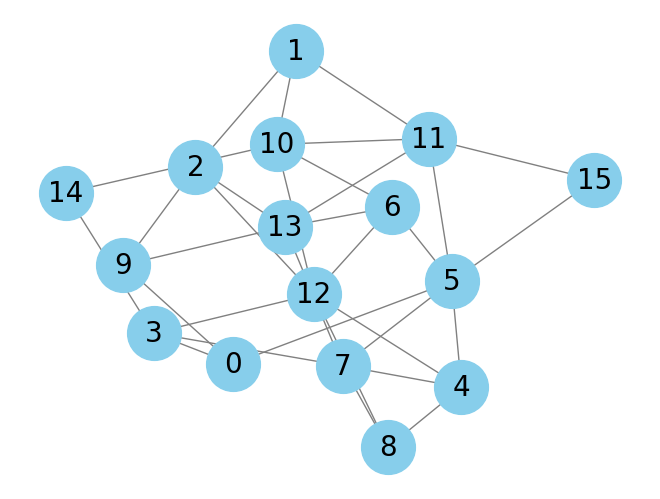

In [12]:
nx.draw(rnd_graph1, with_labels=True, node_color='skyblue', node_size=1500, edge_color='gray', font_size=20)

In [13]:
data = rnd_graph1
print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.number_of_nodes()}')
print(f'Number of edges: {data.number_of_edges()}')
print(f'Average node degree: {data.number_of_edges() / data.number_of_nodes():.2f}')
print(f'Has self-loops: {nx.number_of_selfloops(data)}')
print(f'Is directed: {data.is_directed()}')

Graph with 16 nodes and 32 edges
Number of nodes: 16
Number of edges: 32
Average node degree: 2.00
Has self-loops: 0
Is directed: False


In [14]:
for node in list(data.nodes()):
    neighbours = []
    for neighbour in nx.neighbors(data, node):
        neighbours.append(neighbour)
    print(f"Neighbours of node {node} are {neighbours}")


Neighbours of node 0 are [3, 9, 5]
Neighbours of node 1 are [2, 11, 10]
Neighbours of node 2 are [1, 12, 13, 9]
Neighbours of node 3 are [0, 7, 14, 12]
Neighbours of node 4 are [7, 12, 5, 8]
Neighbours of node 5 are [6, 15, 0, 4, 7, 11]
Neighbours of node 6 are [5, 10, 13, 12]
Neighbours of node 7 are [3, 4, 13, 8, 5]
Neighbours of node 8 are [7, 12, 4]
Neighbours of node 9 are [0, 13, 2]
Neighbours of node 10 are [11, 12, 6, 1, 14]
Neighbours of node 11 are [10, 1, 5, 13, 15]
Neighbours of node 12 are [10, 2, 8, 3, 4, 6]
Neighbours of node 13 are [7, 9, 2, 6, 11]
Neighbours of node 14 are [3, 10]
Neighbours of node 15 are [5, 11]


# Creating Model Definitions 

* Step 1: Create 3x3 Convolution Stride 2 followed by 1x1 Convolution Stride 1.
* Step 2: Create ReLU-convolution-BN triplet.
* Step 3: Transformation Layer for aggregating.
* Step 4: Combining all the layers and aggregating from Source Node -> Sink Node
  
<center>
    <img src="images/img1.png" alt="fishy" class="bg-primary" width="200px">
</center>


In [15]:
# Step 1: Create 3x3 Convolution Stride 2 followed by 1x1 Convolution Stride 1.
class SepConv2d(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_length=3, dilation_size=1, padding_size=1, stride_length=1, bias_flag=True):
        super(SepConv2d, self).__init__()
        self.conv_layer = nn.Conv2d(input_ch, input_ch, kernel_length, stride_length, padding_size, dilation_size, bias=bias_flag, groups=input_ch)
        self.single_layer = nn.Conv2d(input_ch, output_ch, kernel_size=1, stride=1, padding=0, dilation=1, groups=1, bias=bias_flag)

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.single_layer(x)
        return x

In [16]:
# Step 2: Create ReLU-convolution-BN triplet.
class UnitLayer(nn.Module):
    def __init__(self, input_ch, output_ch, stride_length=1):
        super(UnitLayer, self).__init__()

        self.dropout = 0.3

        self.unit_layer = nn.Sequential(
            nn.ReLU(),
            SepConv2d(input_ch, output_ch, stride_length=stride_length),
            nn.BatchNorm2d(output_ch),
            nn.Dropout(self.dropout)
        )

    def forward(self, x):
        return self.unit_layer(x)

In [17]:
# Step 3: Transformation Layer for aggregating.
class GraphNode(nn.Module):
    def __init__(self, input_degree, input_ch, output_ch, stride_length=1):
        super(GraphNode, self).__init__()
        self.input_degree = input_degree
        if len(self.input_degree) > 1:
            self.params = nn.Parameter(torch.ones(len(self.input_degree), requires_grad=True))
        self.unit_layer = UnitLayer(input_ch, output_ch, stride_length=stride_length)

    def forward(self, *ip):
        if len(self.input_degree) > 1:
            op = ip[0] * torch.sigmoid(self.params[0])
            for idx in range(1, len(ip)):
                op += (ip[idx] * torch.sigmoid(self.params[idx]))
            return self.unit_layer(op)
        else:
            return self.unit_layer(ip[0])

In [18]:
#Step 4: Combining all the layers and aggregating from Source Node -> Sink Node

class RandWireGraph(nn.Module):
    def __init__(self, num_nodes, graph_prob, input_ch, output_ch, train_mode, graph_name):
        super(RandWireGraph, self).__init__()
        self.num_nodes = num_nodes
        self.graph_prob = graph_prob
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.train_mode = train_mode
        self.graph_name = graph_name

        # Create a Graph and Get Node Details and Input Edges 
        rnd_graph_node = rand_graph(self.num_nodes, self.graph_prob)
        if self.train_mode is True:
            rnd_graph = rnd_graph_node.make_graph()
            self.node_list, self.incoming_edge_list = rnd_graph_node.get_graph_config(rnd_graph)
            rnd_graph_node.save_graph(rnd_graph, graph_name)
        else:
            rnd_graph = rnd_graph_node.load_graph(graph_name)
            self.node_list, self.incoming_edge_list = rnd_graph_node.get_graph_config(rnd_graph)

        # Define for Source Node
        self.list_of_modules = nn.ModuleList([GraphNode(self.incoming_edge_list[0], self.input_ch, self.output_ch, 
                                                        stride_length=2)])
        # define for rest of the Nodes
        self.list_of_modules.extend([GraphNode(self.incoming_edge_list[n], self.output_ch, self.output_ch) 
                                     for n in self.node_list if n > 0])

    def forward(self, x):
        mem_dict = {}
        # start vertex
        op = self.list_of_modules[0](x)
        mem_dict[0] = op

        # the rest vertex
        for n in range(1, len(self.node_list) - 1):
            if len(self.incoming_edge_list[n]) > 1:
                op = self.list_of_modules[n](*[mem_dict[incoming_vtx] 
                                                       for incoming_vtx in self.incoming_edge_list[n]])
            else:
                op = self.list_of_modules[n](mem_dict[self.incoming_edge_list[n][0]])
            
            mem_dict[n] = op
            
        op = mem_dict[self.incoming_edge_list[self.num_nodes + 1][0]]
        for incoming_vtx in range(1, len(self.incoming_edge_list[self.num_nodes + 1])):
            op += mem_dict[self.incoming_edge_list[self.num_nodes + 1][incoming_vtx]]
        return op / len(self.incoming_edge_list[self.num_nodes + 1])

# Create the RandWire Neural Network Model

In [19]:
class RandWireNNModel(nn.Module):
    
    def __init__(self, num_nodes, graph_prob, input_ch, output_ch, train_mode, dropout, class_num):
        super(RandWireNNModel, self).__init__()
        self.num_nodes = num_nodes
        self.graph_prob = graph_prob
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.train_mode = train_mode
        self.dropout = dropout
        self.class_num = class_num
            
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.output_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.output_ch),
        )

        self.conv_layer_2 = nn.Sequential(
            RandWireGraph(self.num_nodes, self.graph_prob, self.input_ch, self.output_ch*2, self.train_mode, 
                          graph_name="conv_layer_2")
        )
        self.conv_layer_3 = nn.Sequential(
            RandWireGraph(self.num_nodes, self.graph_prob, self.input_ch*2, self.output_ch*4, self.train_mode, 
                          graph_name="conv_layer_3")
        )
        self.conv_layer_4 = nn.Sequential(
            RandWireGraph(self.num_nodes, self.graph_prob, self.input_ch*4, self.output_ch*8, self.train_mode, 
                          graph_name="conv_layer_4")
        )

        self.classifier_layer = nn.Sequential(
            nn.Conv2d(in_channels=self.input_ch*8, out_channels=1280, kernel_size=1),
            nn.BatchNorm2d(1280)
        )

        self.output_layer = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(1280, self.class_num)
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_4(x)
        x = self.classifier_layer(x)

        # Global average pooling
        _, _, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = torch.squeeze(x)
        x = self.output_layer(x)

        return x

# Training Loop

In [20]:
def initialize_weights(layer):
    if isinstance(layer, nn.Conv2d):
        torch.nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            torch.nn.init.zeros_(layer.bias)

In [21]:
rand_wire_model = RandWireNNModel(num_nodes, graph_probability, node_channel_count, node_channel_count, train_mode,dropout,class_num).to(device)

In [24]:
from torchsummary import summary
summary(rand_wire_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 112, 112]             640
            Conv2d-5        [-1, 128, 112, 112]           8,320
         SepConv2d-6        [-1, 128, 112, 112]               0
       BatchNorm2d-7        [-1, 128, 112, 112]             256
           Dropout-8        [-1, 128, 112, 112]               0
         UnitLayer-9        [-1, 128, 112, 112]               0
        GraphNode-10        [-1, 128, 112, 112]               0
             ReLU-11        [-1, 128, 112, 112]               0
           Conv2d-12        [-1, 128, 112, 112]           1,280
           Conv2d-13        [-1, 128, 112, 112]          16,512
        SepConv2d-14        [-1, 128, 1

In [25]:
rand_wire_model = rand_wire_model.apply(initialize_weights)

In [ ]:
optim_module = optim.SGD(rand_wire_model.parameters(), lr=lrate, weight_decay=1e-4, momentum=0.8)
loss_func = nn.CrossEntropyLoss().to(device)

epochs = []
test_accuracies = []
training_accuracies = []
training_losses = []
test_losses = []
best_test_accuracy = 0

start_time = time.time()
for ep in range(1, num_epochs + 1):
    epochs.append(ep)
    training_loss, training_accuracy = train(rand_wire_model, train_dataloader, optim_module, loss_func, ep, num_epochs, lrate)
    test_loss, test_accuracy = test(rand_wire_model, loss_func, test_dataloader)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)
    print('Current test acc: {0:.2f}%, best test acc: {1:.2f}%'.format(test_accuracy, best_test_accuracy))

    if best_test_accuracy < test_accuracy:
        model_state = {
            'model': rand_wire_model.state_dict(),
            'accuracy': test_accuracy,
            'ep': ep,
        }
        if not os.path.isdir('model_checkpoint'):
            os.mkdir('model_checkpoint')
        model_filename = "ch_count_" + str(node_channel_count) + "_prob_" + str(graph_probability)
        torch.save(model_state, './model_checkpoint/' + model_filename + 'ckpt.t7')
        best_test_accuracy = test_accuracy
        plot_results(epochs, training_losses, training_accuracies, test_accuracies)
    print("model train time: ", time.time() - start_time)

epoch: 1, steps:100, loss: 1.4328498840332031, accuracy: 0.609375
epoch: 1, steps:200, loss: 0.9221280217170715, accuracy: 0.703125
epoch: 1, steps:300, loss: 0.9974449276924133, accuracy: 0.703125
epoch: 1, steps:400, loss: 0.8982795476913452, accuracy: 0.625
epoch: 1, steps:500, loss: 0.9741153717041016, accuracy: 0.625
epoch: 1, steps:600, loss: 1.0132979154586792, accuracy: 0.671875
epoch: 1, steps:700, loss: 0.9180873036384583, accuracy: 0.703125
Epoch 2/50 | Loss: 1.0326 | Train Accuracy: 40.8517 | Learning Rate: 0.09990133642141358

Test set: Average loss: 0.0173, Accuracy: 6474/10000 (65%)

Current test acc: 64.74%, best test acc: 0.00%
model train time:  62.70549702644348
epoch: 2, steps:200, loss: 0.9816213846206665, accuracy: 0.671875
epoch: 2, steps:400, loss: 0.9253632426261902, accuracy: 0.6875
epoch: 2, steps:600, loss: 0.9421725869178772, accuracy: 0.671875
epoch: 2, steps:800, loss: 0.9344247579574585, accuracy: 0.609375
epoch: 2, steps:1000, loss: 1.2557295560836792, 

## Loading the Model and Predicting for any given Image

In [ ]:
# Initialize a model
train_mode = False
rand_wire_loaded_model = RandWireNNModel(num_nodes, graph_probability, node_channel_count, node_channel_count,train_mode,dropout,class_num).to(device)

In [ ]:
# Code to load checkpoint data
root_path = f'/mnt/f/Rohan/Ubuntu_2204/projects/mastering_pytorch/rand_wire_nn/model_checkpoint/'
model_checkpoint_path = f"ch_count_{str(node_channel_count)}_prob_{str(graph_probability)}ckpt.t7"
model_path = root_path + model_checkpoint_path
model_checkpoint = torch.load(model_path)
rand_wire_loaded_model.load_state_dict(model_checkpoint['model'])

In [ ]:
#Code to load a random image from the test data set
# Recovers the original `dataset` from the `dataloader`
dataset = test_dataloader.dataset
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Get a random sample
random_index = int(np.random.random()*len(dataset))
image, label = dataset[random_index]
img = torch.permute(image,(2,1,0))
img = np.array(img)
img = img / 2 + 0.5 

#Prediction from the trained model
image = image.to(device)
image1 = image.unsqueeze(1)
image1 = image1.permute(1,0,2,3)
pred = rand_wire_loaded_model(image1)
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.title(f'Actual:{classes[label]}   Predicted :{classes[np.array(pred.argmax().cpu())]}')
plt.show()